# Analysis of the vocabulary for the online experiment

Unless otherwise stated, the vocabulary we analyse here is the whole set of candidate words for the online experiment: nouns or proper nouns whose level of acquisition was identifiable and which were not deemed meta-mathematical or too polysemic.

The final vocabulary for this experiment is only a subset of these words, as we excluded some pairs in order to control the distribution of estimated similarities of pairs within each level.

## Loading data

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ast

In [3]:
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
df = pd.read_csv('../OnlineExperiment/utils/finalVocab_French.csv', encoding='utf-8', index_col='word', dtype={'levelId': int, 'metaMaths': bool, 'tooPolysemic': bool, 'mathsFrequency': float, 'nonMathsFrequency': float}, converters={'grammaticalForm': (lambda x: ast.literal_eval(x))})

In [5]:
orderedLevelNames = ['primaire', '6e-5e', '4e-3e', '2nd', '1ere-Tale', 'prépa', 'licence', 'master']

In [6]:
df

,mathsFrequency,nonMathsFrequency,levelId,levelName,metaMaths,tooPolysemic,grammaticalForm
word,,,,,,,
un,0.028114,0.018411,0,primaire,False,False,[nombre]
nombre,0.003271,0.000283,0,primaire,False,False,[nom]
$\mathbb{N}$,0.002694,0.001004,3,2nd,False,False,[symbole]
deux,0.002393,0.001415,0,primaire,False,False,[nombre]
fonction,0.002376,0.000179,2,4e-3e,False,False,[nom]
...,...,...,...,...,...,...,...
dièdre,0.000007,0.000000,6,licence,False,False,[nom]
distributivité,0.000007,0.000000,2,4e-3e,False,False,[nom]
autocorrélation,0.000006,0.000000,6,licence,False,False,[nom]


## Number of words by level

In [7]:
df.groupby('levelName').size()

levelName
1ere-Tale     49
2nd           38
4e-3e         25
6e-5e         53
licence       45
master        18
primaire     110
prépa         91
dtype: int64

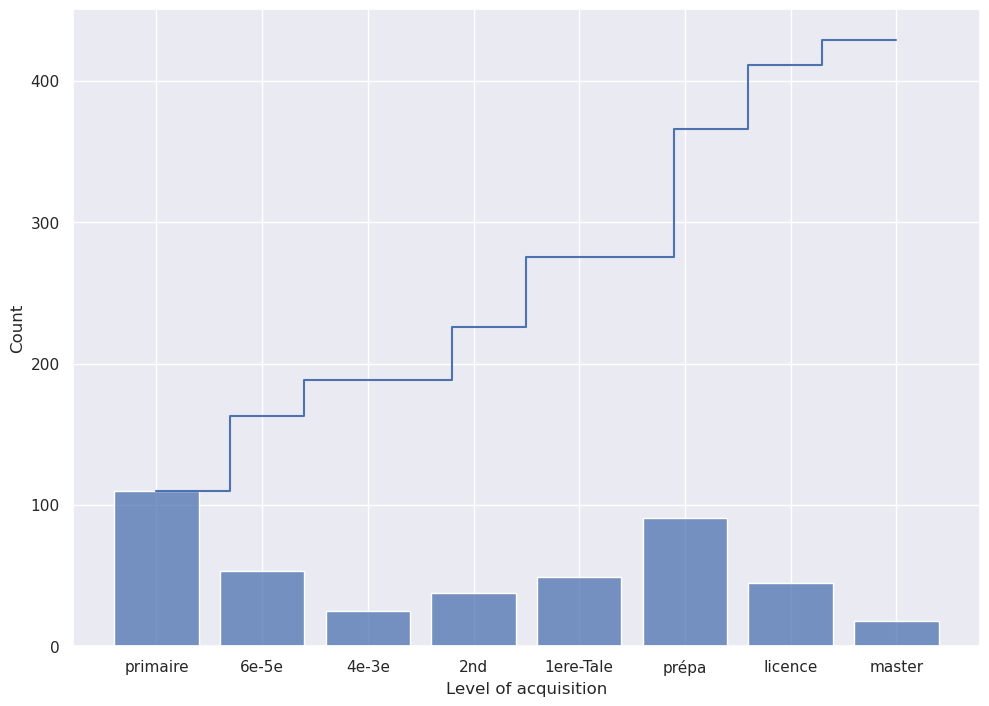

In [8]:
sns.histplot(data=df, x='levelId', discrete=True, shrink=.8)
sns.histplot(data=df, x='levelId', cumulative=True, fill=False, element='step')
plt.xticks(ticks=np.arange(8), labels=orderedLevelNames)
plt.xlabel('Level of acquisition')
plt.show()

## Word length analysis

In [9]:
def wordLength(w):
    if w[0] == '$':
        return 1
    return len(w)

df['wordLength'] = [wordLength(x) for x in df.index]

### ANOVA

In [10]:
model = ols('wordLength ~ C(levelName)', data=df)
results = model.fit()
anova = sm.stats.anova_lm(results, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(levelName),422.575042,7.0,7.832086,6.279003e-09
Residual,3244.968081,421.0,NaN,NaN


### Plots

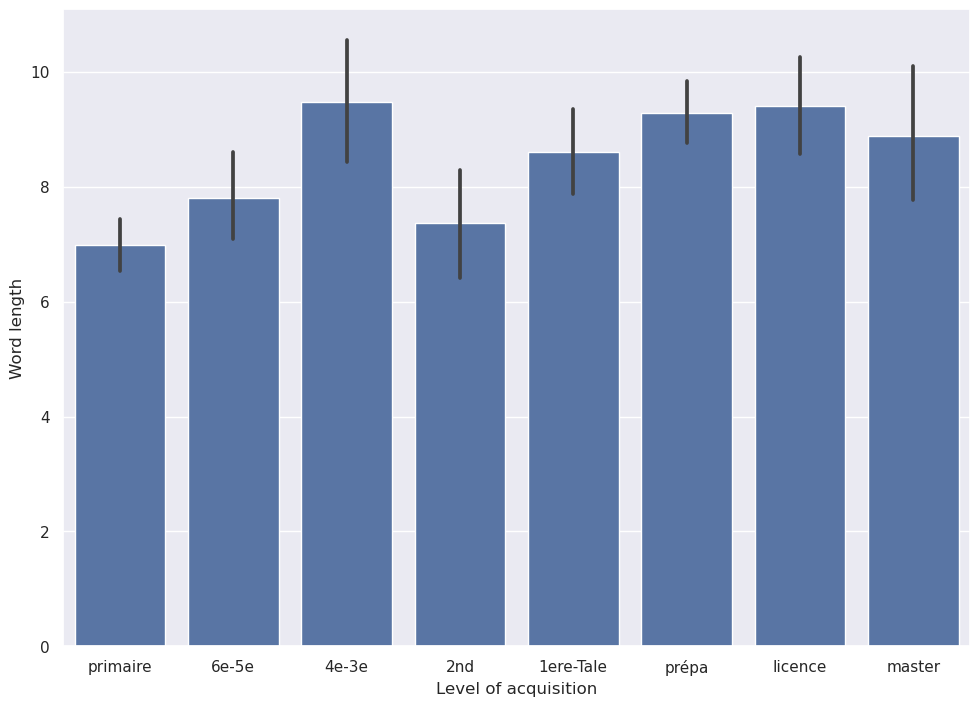

In [11]:
sns.barplot(data=df, x='levelId', y='wordLength', color=sns.color_palette()[0])
plt.xticks(ticks=np.arange(8), labels=orderedLevelNames)
plt.xlabel('Level of acquisition')
plt.ylabel('Word length')
plt.show()

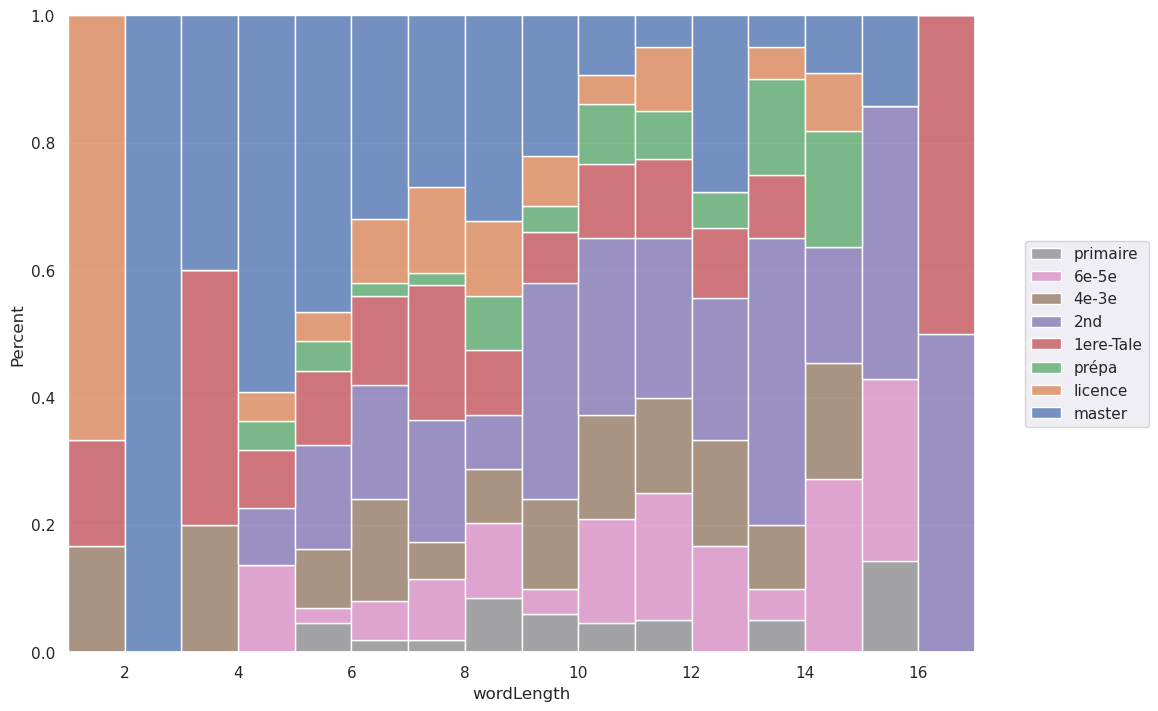

In [12]:
sns.histplot(data=df, x='wordLength', hue='levelName', multiple='fill', stat='percent')
plt.legend(orderedLevelNames, loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.show()

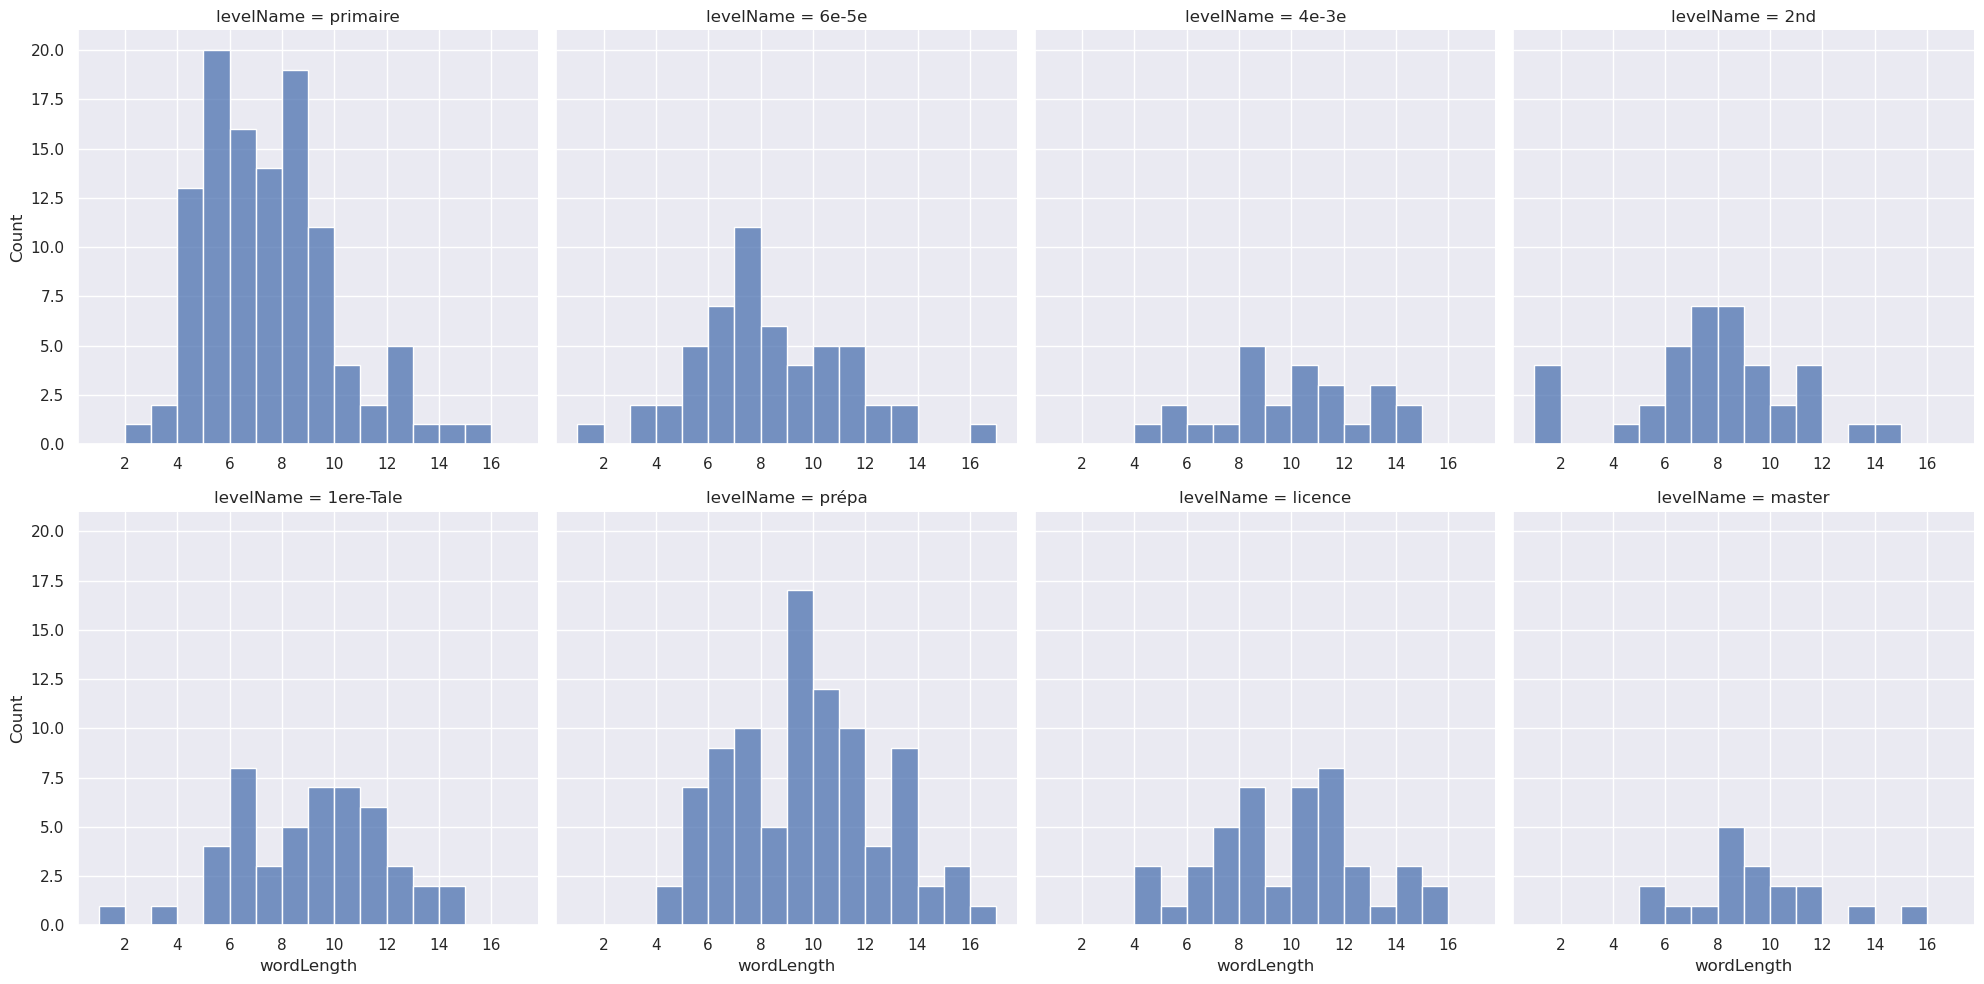

In [13]:
sns.displot(data=df, x='wordLength', kind='hist', col='levelName', col_order=orderedLevelNames, col_wrap=4, facet_kws={'sharex':False})
plt.show()

## Word frequency analysis

In [14]:
df['relativeFrequency'] = [np.log10(x.mathsFrequency)-np.log10(x.nonMathsFrequency) if x.nonMathsFrequency != 0 else np.nan for x in df.itertuples()]
df['mathsFrequency'] = [np.log10(x)+6 for x in df['mathsFrequency']]
df['nonMathsFrequency'] = [np.log10(x)+6 for x in df['nonMathsFrequency']]

/tmp/ipykernel_47898/2922953759.py:3: RuntimeWarning: divide by zero encountered in log10
  df['nonMathsFrequency'] = [np.log10(x)+6 for x in df['nonMathsFrequency']]


### ANOVA

We are looking for two kinds of effects:
* first we want to see if the mathematical frequency or words is significantly different accross levels of education
* second we want to see if the relative frequency of words is significantly different accross levels of education (that is, if at some levels words are much more mathematically tuned than at others)

In [15]:
model = ols('mathsFrequency ~ C(levelName)', data=df)
results = model.fit()
anova = sm.stats.anova_lm(results, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(levelName),24.811360,7.0,10.274922,6.563296e-12
Residual,145.229912,421.0,NaN,NaN


In [16]:
model = ols('relativeFrequency ~ C(levelName)', data=df)
results = model.fit()
anova = sm.stats.anova_lm(results, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(levelName),14.969366,7.0,4.749,0.000044
Residual,140.494022,312.0,NaN,NaN


### Plots

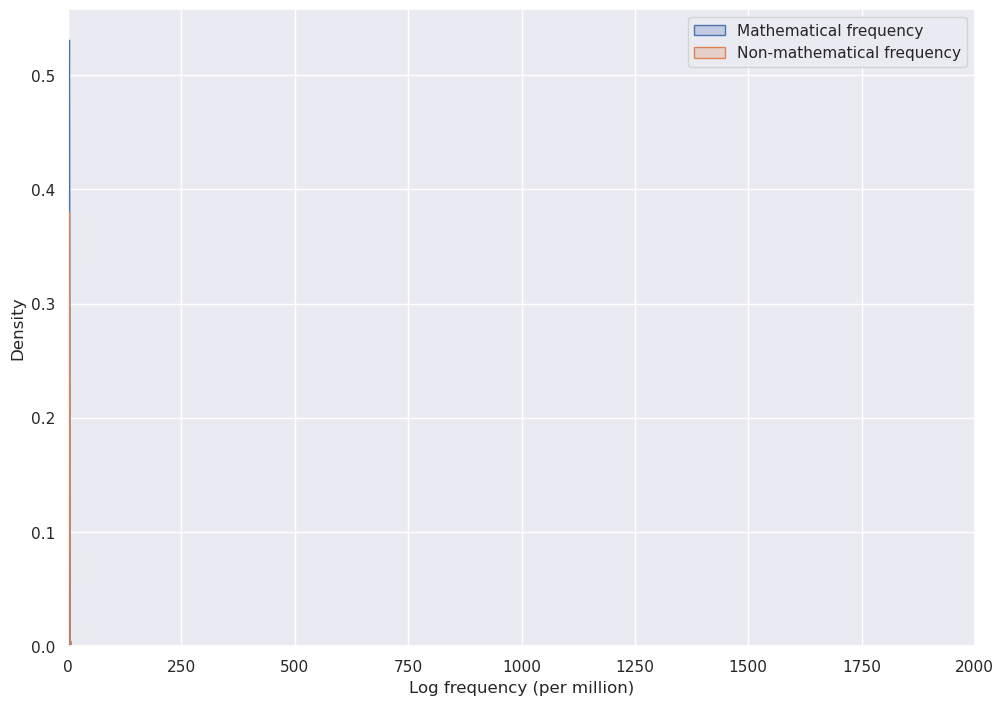

In [17]:
sns.kdeplot(data=df, x='mathsFrequency', fill=True, label='Mathematical frequency')
sns.kdeplot(data=df, x='nonMathsFrequency', fill=True, label='Non-mathematical frequency')
plt.xlim([0,2000])
plt.xlabel('Log frequency (per million)')
plt.legend()
plt.show()

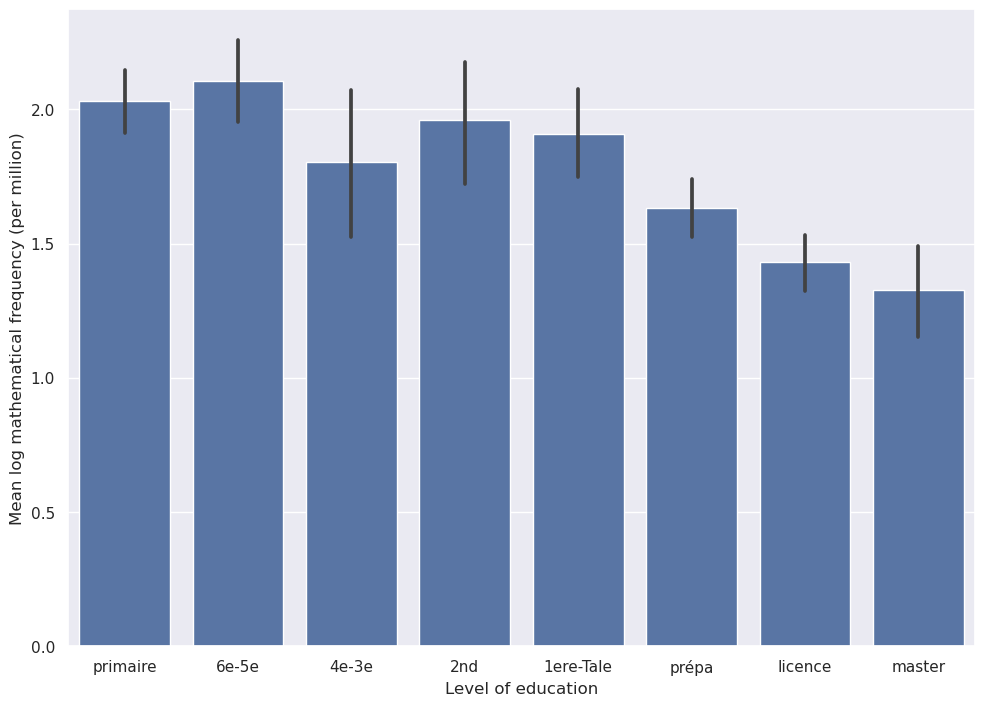

In [18]:
sns.barplot(data=df, x='levelId', y='mathsFrequency', color=sns.color_palette()[0])
plt.xticks(np.arange(8), orderedLevelNames)
plt.xlabel('Level of education')
plt.ylabel('Mean log mathematical frequency (per million)')
plt.show()

/volatile/home/sd268742/anaconda3/envs/mathssim/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


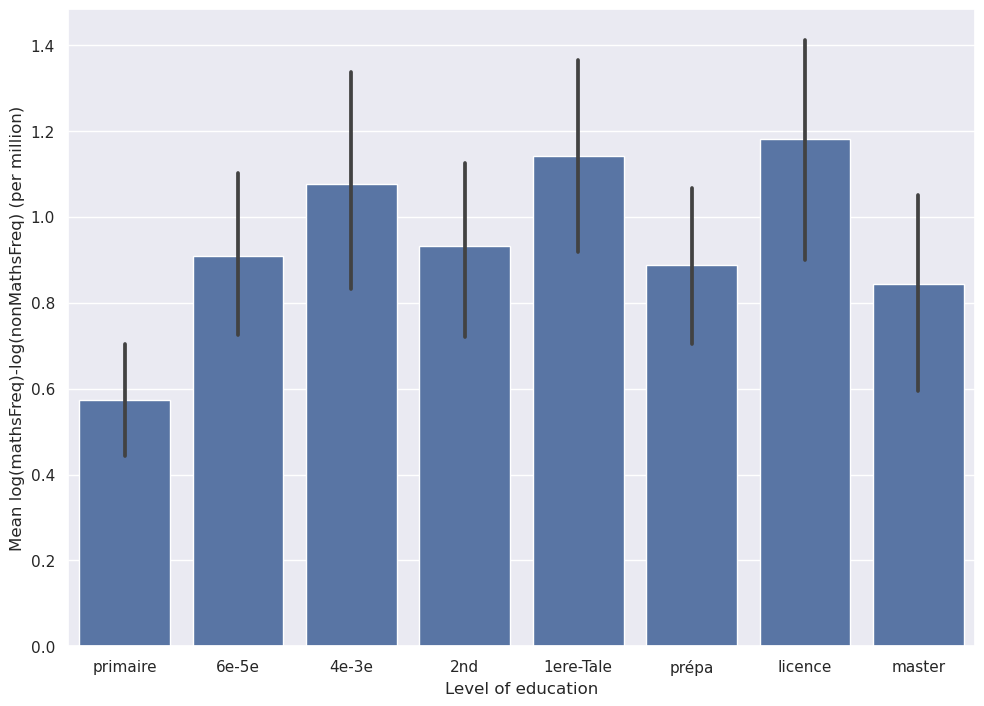

In [19]:
sns.barplot(data=df, x='levelId', y='relativeFrequency', color=sns.color_palette()[0])
plt.xticks(np.arange(8), orderedLevelNames)
plt.xlabel('Level of education')
plt.ylabel('Mean log(mathsFreq)-log(nonMathsFreq) (per million)')
plt.show()

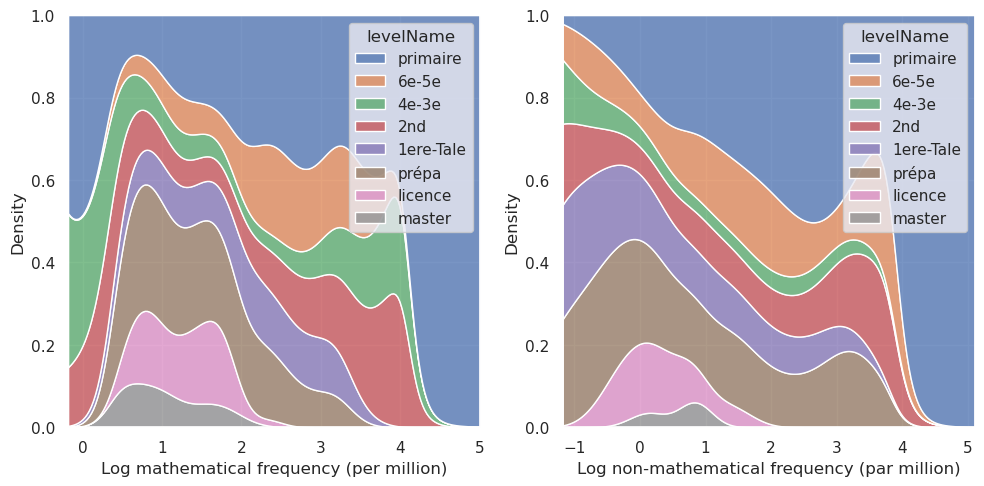

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.kdeplot(data=df, x='mathsFrequency', hue='levelName', hue_order=orderedLevelNames, multiple="fill", ax=ax1)
sns.kdeplot(data=df, x='nonMathsFrequency', hue='levelName', hue_order=orderedLevelNames, multiple="fill", ax=ax2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax1.set_xlabel('Log mathematical frequency (per million)')
ax2.set_xlabel('Log non-mathematical frequency (par million)')
# ax1.set_xlim([0,2000])
# ax2.set_xlim([0,2000])
plt.show()

## Similarity matrix for numbers

In [21]:
allPairs = pd.read_csv('../OnlineExperiment/pairSim_French.csv', encoding='utf-8', dtype={'Similarity': float})

In [22]:
halfNumbers = allPairs.loc[allPairs.word1.apply(lambda x: 'nombre' in df.loc[x].grammaticalForm) & allPairs.word2.apply(lambda x: 'nombre' in df.loc[x].grammaticalForm)].copy()
w1, w2, sim = list(halfNumbers.word1), list(halfNumbers.word2), list(halfNumbers.Similarity)
numbers = pd.DataFrame(np.transpose(np.array([w1+w2, w2+w1, sim*2])), columns=['word1', 'word2', 'Similarity'])
numbers = numbers.astype({"Similarity": float})
numbersPivot = pd.pivot_table(data=numbers, index='word1', columns='word2', values='Similarity', fill_value=1)

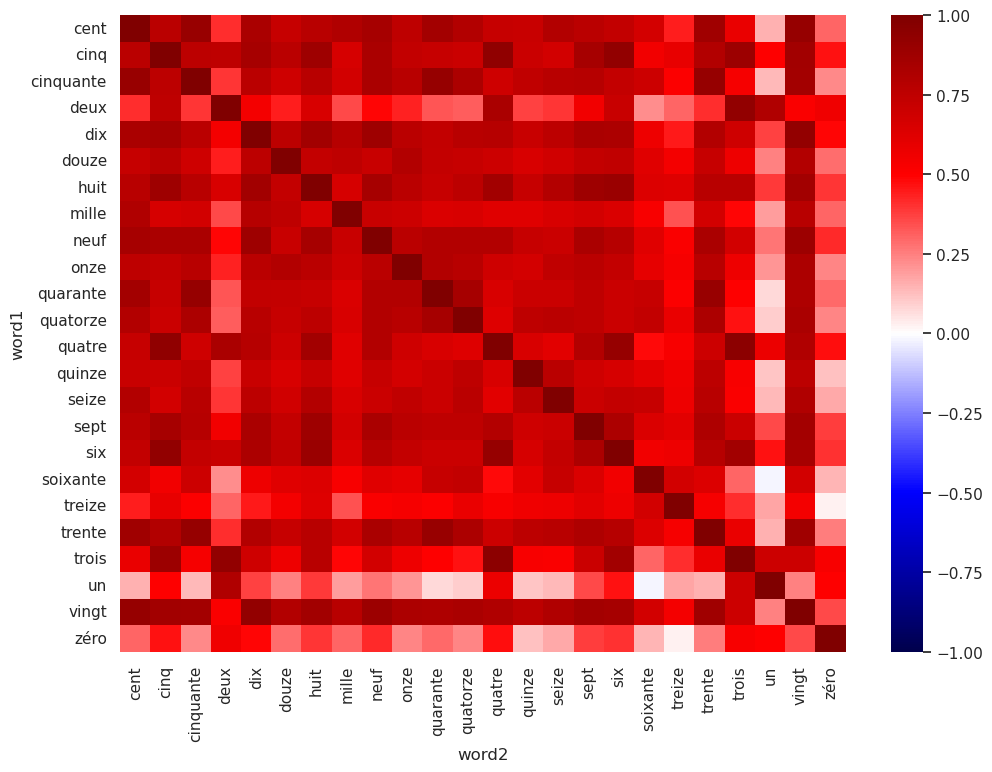

In [23]:
sns.heatmap(numbersPivot, vmin=-1, vmax=1, cmap="seismic")
plt.show()

## Distribution of similarity in selected pairs 

In this part, we only analyse the pairs selected for the online experiment.

In [24]:
selectedPairsList = [pd.read_csv(f'../Data/FrenchPairs/selectedPairs_{level}.csv', encoding='utf-8', dtype={'Similarity': float}) for level in [0,2,4,5,7]]
selectedPairs = pd.concat(selectedPairsList)

In [32]:
selectedPairs.groupby("Level").count()

,PairID,word1,word2,Similarity,SimCategory
Level,,,,,
0,1021,1021,1021,1021,1021
1,472,472,472,472,472
2,202,202,202,202,202
3,334,334,334,334,334
4,433,433,433,433,433
5,789,789,789,789,789
6,370,370,370,370,370
7,135,135,135,135,135


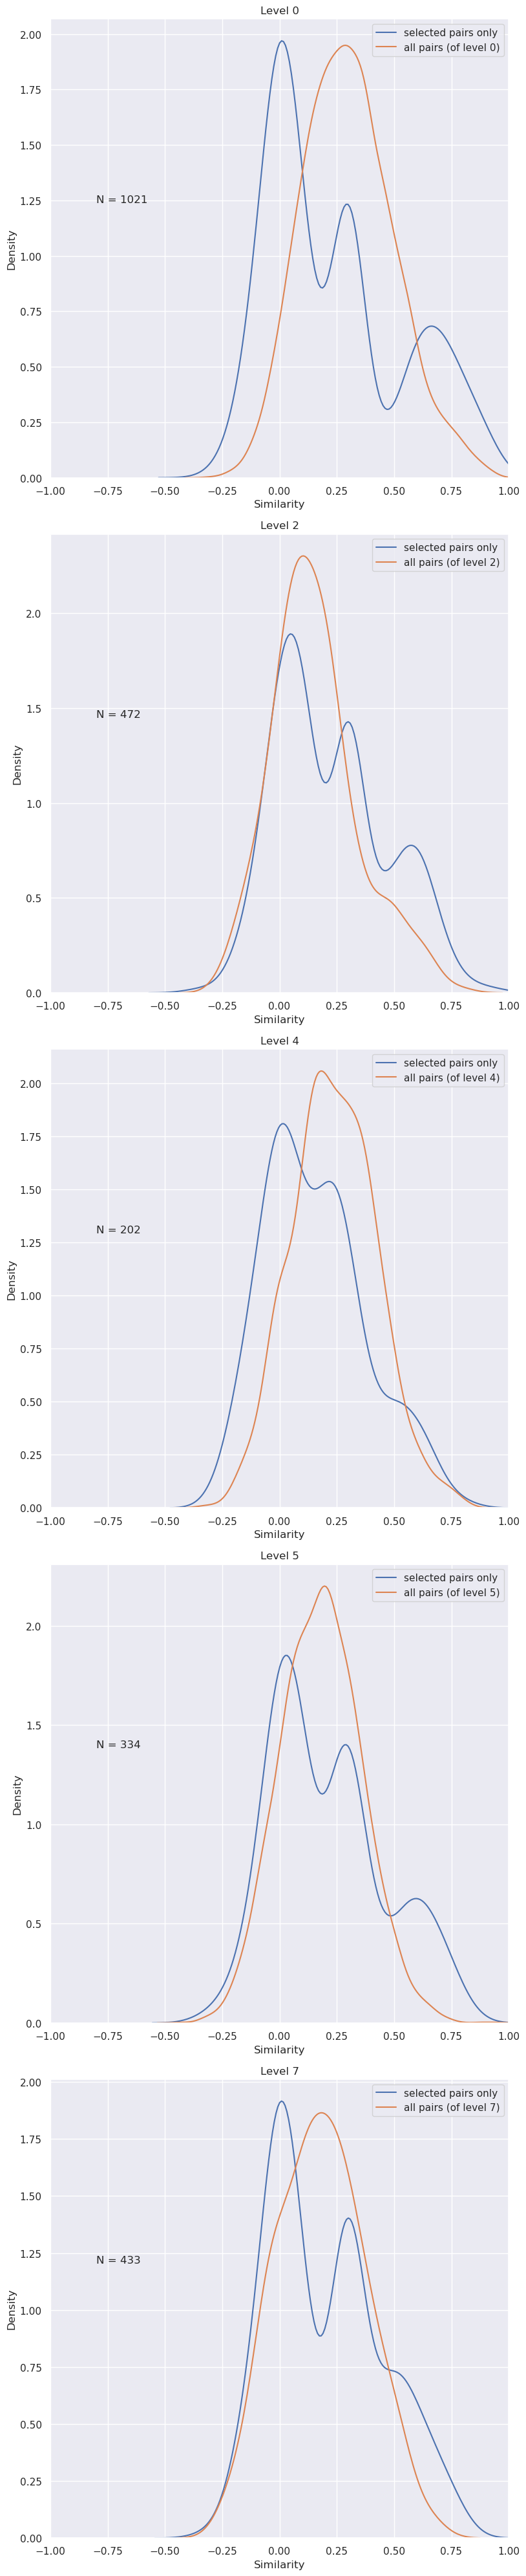

In [29]:
sns.set(rc={'figure.figsize':(40,40)})
fig, ax = plt.subplots(5, 1)
for i, level in zip(range(5), [0,2,4,5,7]):
    selectedLevelPairs = selectedPairs.loc[selectedPairs.Level == i]
    allLevelPairs = allPairs.loc[allPairs.Level == level]
    sns.kdeplot(data=selectedLevelPairs, x='Similarity', label='selected pairs only', ax=ax[i], color=sns.color_palette()[0])
    sns.kdeplot(data=allLevelPairs, x='Similarity', label=f'all pairs (of level {level})', ax=ax[i], color=sns.color_palette()[1])
    ax[i].text(.1, .6, f"N = {len(selectedLevelPairs)}", transform=ax[i].transAxes)
    ax[i].set_xlim([-1,1])
    ax[i].set_title(f'Level {level}')
    ax[i].set_box_aspect(1)
    ax[i].legend()
    plt.tight_layout()
plt.show()